## Import

In [1]:
#!nvidia-smi

In [1]:
!pip install -U -q sklearn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import random
import pandas as pd
import numpy as np
import os
import re

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


## Hyperparameter Setting

In [4]:
CFG = {
    'X_RANGE': 7, # 예측하려는 시점을 X_RANGE 만큼의 이전 일자의 데이터로부터 예측 및 학습
    'EPOCHS': 100,
    'LEARNING_RATE': 1e-2,
    'BATCH_SIZE': 128,
    'SEED': 42
}

## Fixed RandomSeed

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load

In [6]:
path = '/home/work/dacon/'

train = pd.read_csv(path+'data/train_features.csv')

In [7]:
train.head()

,일시,광진구,동대문구,성동구,중랑구,광진구_따릉이대여소,동대문구_따릉이대여소,성동구_따릉이대여소,중랑구_따릉이대여소,광진구_하차총승객수_mean,...,광진구_하차총승객수_size,동대문구_하차총승객수_mean,동대문구_하차총승객수_sum,동대문구_하차총승객수_size,성동구_하차총승객수_mean,성동구_하차총승객수_sum,성동구_하차총승객수_size,중랑구_하차총승객수_mean,중랑구_하차총승객수_sum,중랑구_하차총승객수_size
0,20180101,0.592,0.368,0.580,0.162,50,49,56,49,82.662011,...,716.0,77.275727,98372.0,1273.0,52.757804,49012.0,929.0,48.556989,67737.0,1395.0
1,20180102,0.840,0.614,1.034,0.260,50,49,56,49,153.631799,...,717.0,164.542678,210121.0,1277.0,119.766845,111982.0,935.0,101.391273,141745.0,1398.0
2,20180103,0.828,0.576,0.952,0.288,50,49,56,49,157.090028,...,722.0,171.693271,219424.0,1278.0,124.080386,115767.0,933.0,103.943732,145937.0,1404.0
3,20180104,0.792,0.542,0.914,0.292,50,49,56,49,158.410864,...,718.0,169.996868,217086.0,1277.0,123.266026,115377.0,936.0,103.883440,146164.0,1407.0
4,20180105,0.818,0.602,0.994,0.308,50,49,56,49,162.026207,...,725.0,174.865415,223478.0,1278.0,126.241453,118162.0,936.0,107.236299,150667.0,1405.0


In [8]:
train['일시'].min(), train['일시'].max()

(20180101, 20211231)

## Data Visualization

In [9]:
def get_view_df(df, target):
    viewd = df[['일시', target]]
    viewd = viewd.reset_index(drop=True)
    viewd = viewd.reset_index()
    print(target)
    sns.set(rc={'figure.figsize':(30, 8)})
    sns.lineplot(x='index', y=target, data=viewd)
    plt.show()

광진구


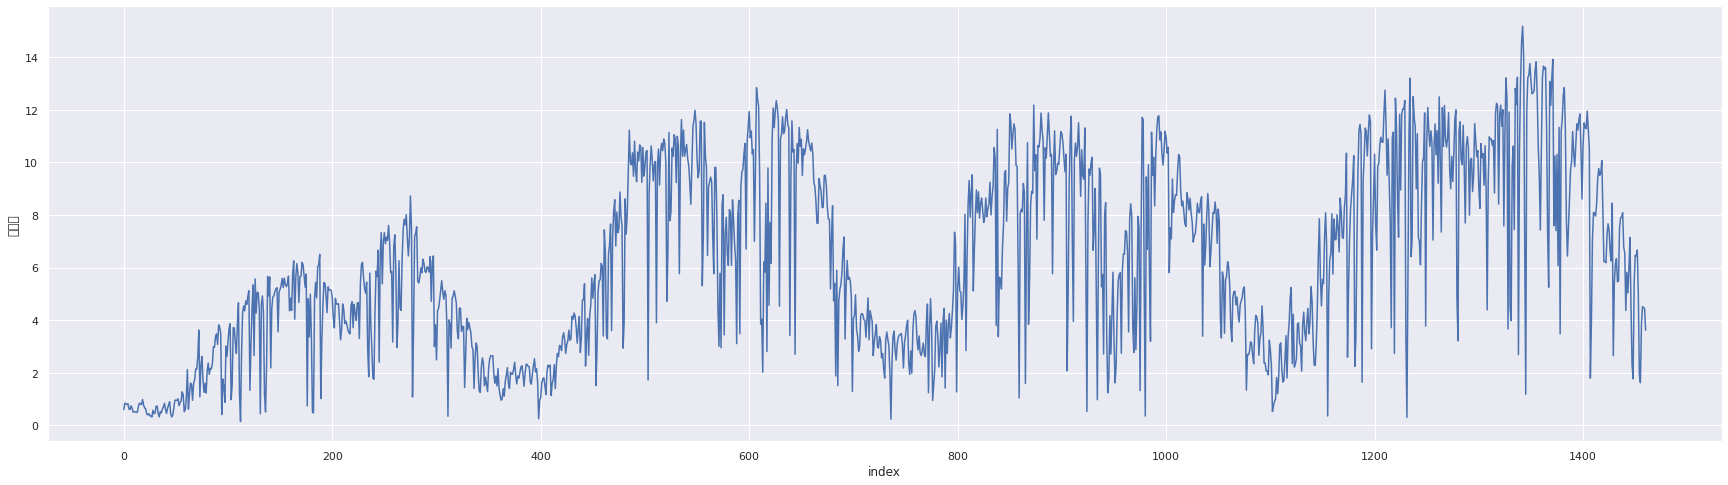

동대문구


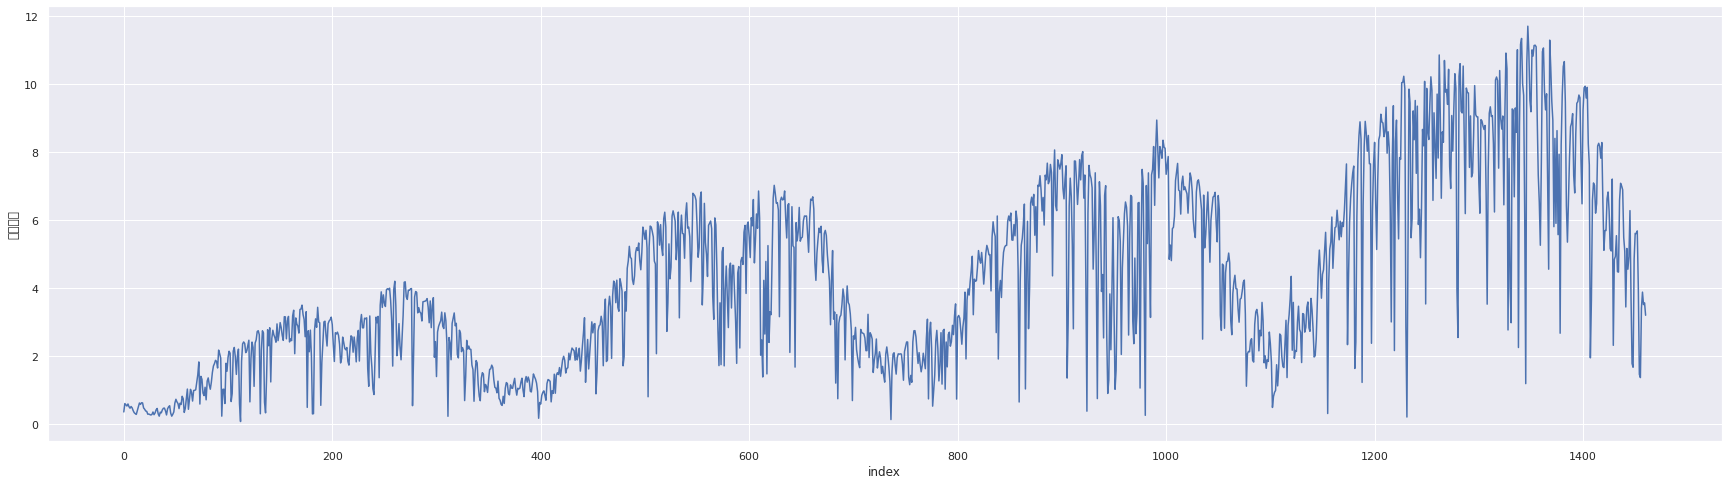

성동구


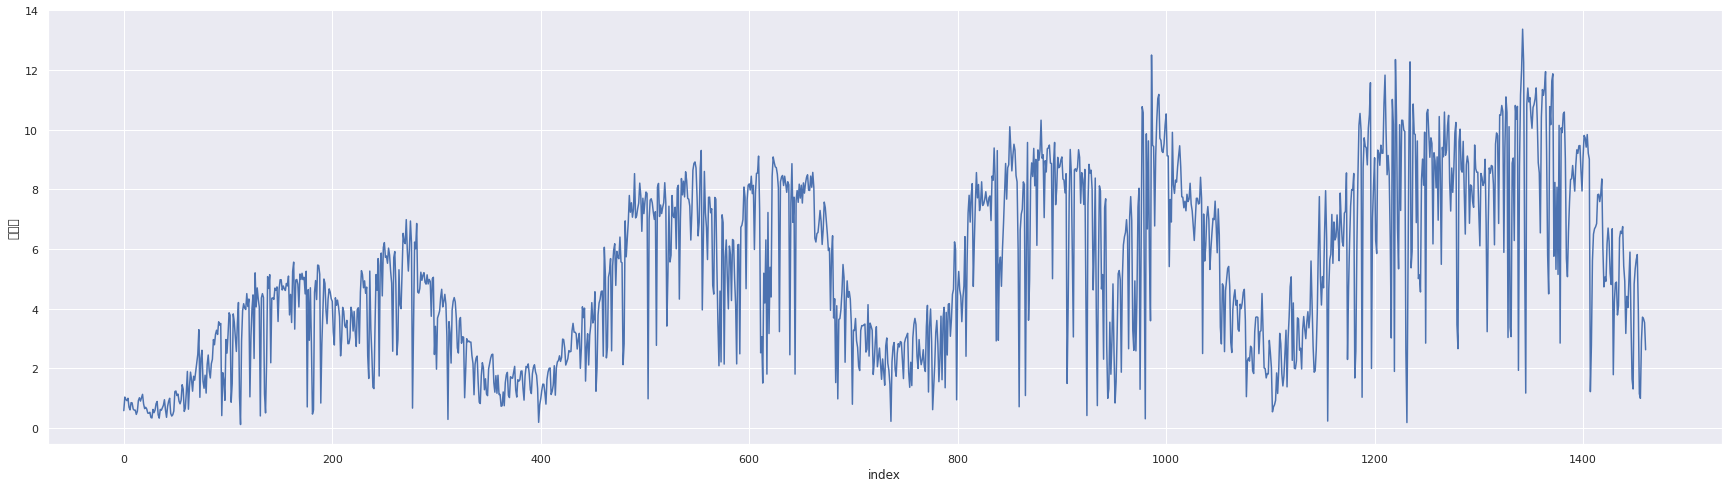

중랑구


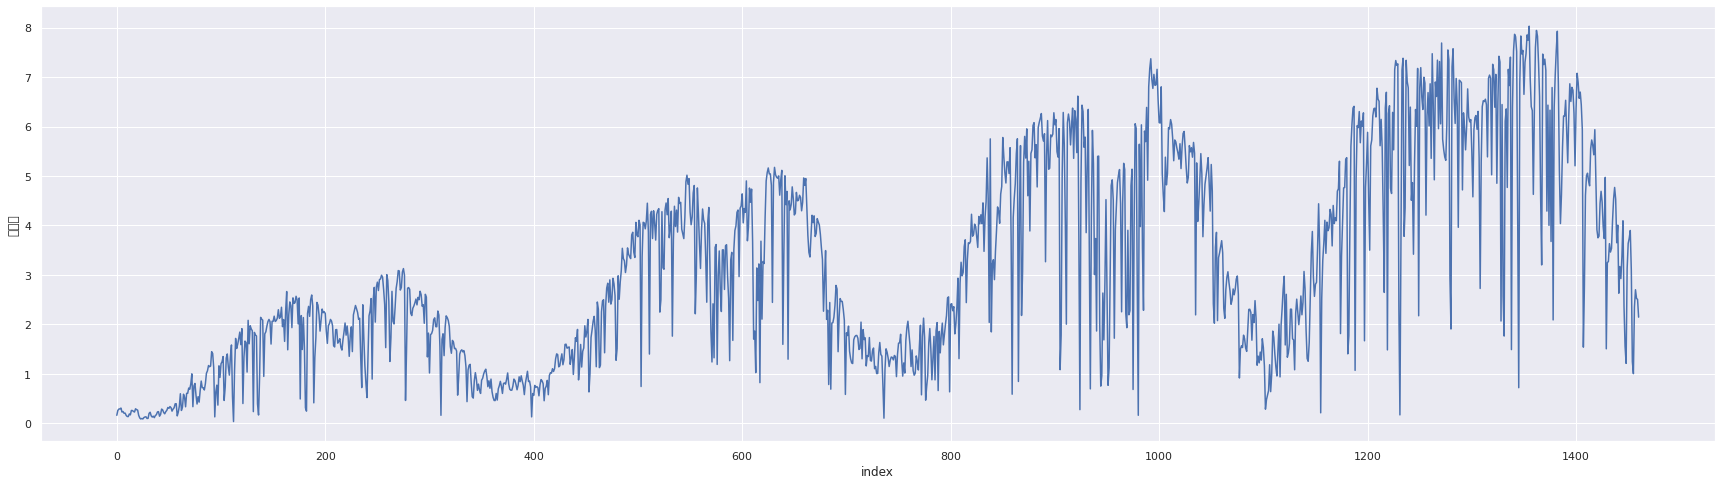

In [10]:
get_view_df(train, '광진구')
get_view_df(train, '동대문구')
get_view_df(train, '성동구')
get_view_df(train, '중랑구')

## Seasonal Decompose

In [11]:
from datetime import datetime

train['일시'] = train.일시.apply(lambda x: datetime.strptime(str(x),'%Y%m%d'))
train.set_index('일시', inplace=True)

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

def func_diff(location, lamb):
    # 계절성 제거
    result = seasonal_decompose(train['{}'.format(location)], model='additive')
    result = result.observed
    
    # 추세 변동요인 추출 - trend
    cycle, trend = sm.tsa.filters.hpfilter(result, lamb)
    data_불규칙 = pd.DataFrame(cycle)

    # 불규칙 변동요인 제거한 순환변동요인 추출 - cycle2
    unrule, cycle2 = sm.tsa.filters.hpfilter(data_불규칙, lamb)

    # 표준화
    cycle_std = (cycle2-np.mean(cycle2))/np.std(cycle2)

    train['cycle_{}'.format(location)] = cycle_std
    train['unrule_{}'.format(location)] = unrule
    train['trend_{}'.format(location)] = trend

In [13]:
func_diff('광진구', 6000) #129600
func_diff('동대문구', 6000)
func_diff('성동구', 6000)
func_diff('중랑구', 6000)

In [14]:
train = train.reset_index()
train['일시'] = train['일시'].astype(str)

## Train / Validation Split

In [15]:
lst = ['광진구_따릉이대여소', '동대문구_따릉이대여소', '성동구_따릉이대여소', '중랑구_따릉이대여소', 
         '광진구_하차총승객수_mean', '광진구_하차총승객수_sum', '광진구_하차총승객수_size', 
         '동대문구_하차총승객수_mean', '동대문구_하차총승객수_sum', '동대문구_하차총승객수_size', 
         '성동구_하차총승객수_mean', '성동구_하차총승객수_sum', '성동구_하차총승객수_size', 
         '중랑구_하차총승객수_mean', '중랑구_하차총승객수_sum', '중랑구_하차총승객수_size']

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train[lst] = scaler.fit_transform(train[lst])

In [16]:
val_df = train.iloc[1096-CFG['X_RANGE']:].reset_index().drop(columns='index') # 20210101 ~ 20211231
# 위의 1096-CFG['X_RANGE']의 이유는 20210101을 예측하기 위해서는 이전 X_RANGE만큼의 일수가 필요하므로
train_df = train.iloc[:1096].reset_index().drop(columns='index') # 20180101 ~ 20201231

In [17]:
train_df.shape, val_df.shape

((1096, 33), (372, 33))

In [18]:
train_df.columns

Index(['일시', '광진구', '동대문구', '성동구', '중랑구', '광진구_따릉이대여소', '동대문구_따릉이대여소',
       '성동구_따릉이대여소', '중랑구_따릉이대여소', '광진구_하차총승객수_mean', '광진구_하차총승객수_sum',
       '광진구_하차총승객수_size', '동대문구_하차총승객수_mean', '동대문구_하차총승객수_sum',
       '동대문구_하차총승객수_size', '성동구_하차총승객수_mean', '성동구_하차총승객수_sum',
       '성동구_하차총승객수_size', '중랑구_하차총승객수_mean', '중랑구_하차총승객수_sum',
       '중랑구_하차총승객수_size', 'cycle_광진구', 'unrule_광진구', 'trend_광진구', 'cycle_동대문구',
       'unrule_동대문구', 'trend_동대문구', 'cycle_성동구', 'unrule_성동구', 'trend_성동구',
       'cycle_중랑구', 'unrule_중랑구', 'trend_중랑구'],
      dtype='object')

## Data Pre-processing

In [19]:
# 광진구, 동대문구, 성동구, 중랑구
def get_x_y_data_feature(df, infer=False):
    # x_range : x일전까지의 데이터를 통해 예측
    x_data = []
    y_data = []
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        x_data.append(np.array(df.loc[i-CFG['X_RANGE']:i-1, df.columns]).astype(float))
        y_data.append(np.array(df.loc[i, ['광진구_따릉이대여소', '동대문구_따릉이대여소',
       '성동구_따릉이대여소', '중랑구_따릉이대여소', '광진구_하차총승객수_mean', '광진구_하차총승객수_sum',
       '광진구_하차총승객수_size', '동대문구_하차총승객수_mean', '동대문구_하차총승객수_sum',
       '동대문구_하차총승객수_size', '성동구_하차총승객수_mean', '성동구_하차총승객수_sum',
       '성동구_하차총승객수_size', '중랑구_하차총승객수_mean', '중랑구_하차총승객수_sum',
       '중랑구_하차총승객수_size', 
       'cycle_광진구', 'unrule_광진구', 'trend_광진구', 'cycle_동대문구', 'unrule_동대문구',
       'trend_동대문구', 'cycle_성동구', 'unrule_성동구', 'trend_성동구', 'cycle_중랑구',
       'unrule_중랑구', 'trend_중랑구']]).astype(float))
    if infer:
        return x_data
    else:
        return x_data, y_data

In [20]:
def make_ymd_feature(df):
    df['일시'] = df['일시'].astype(str)
    df['년'] = df['일시'].str[:4].astype(int)/1000.
    df['월'] = df['일시'].str[5:7].astype(int)/12.
    df['일'] = df['일시'].str[8:10].astype(int)/31.
    
    df = df.drop('일시', axis=1)
    return df

In [21]:
train_df = make_ymd_feature(train_df)
val_df = make_ymd_feature(val_df)

In [22]:
train_x_1, train_y_1 = get_x_y_data_feature(train_df)

  0%|          | 0/1089 [00:00<?, ?it/s]

In [23]:
val_x_1, val_y_1 = get_x_y_data_feature(val_df)

  0%|          | 0/365 [00:00<?, ?it/s]

In [24]:
train_x_1[0].shape

(7, 35)

## CustomDataset

In [25]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        else:
            return torch.Tensor(self.X[index])

    def __len__(self):
        return len(self.X)

In [26]:
train_dataset_1 = CustomDataset(train_x_1, train_y_1)
train_loader_1 = DataLoader(train_dataset_1, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0, drop_last=True)

val_dataset_1 = CustomDataset(val_x_1, val_y_1)
val_loader_1 = DataLoader(val_dataset_1, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0, drop_last=True)

In [27]:
train_dataset_1[0][0].shape, train_dataset_1[0][1].shape

(torch.Size([7, 35]), torch.Size([28]))

## Define Feature Prediction Model

In [28]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.lstm = nn.LSTM(input_size=35, hidden_size=256, num_layers=4, batch_first=True)
        
        self.multioutput_reg = nn.Sequential(
            nn.Linear(in_features=256, out_features=128), 
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=28),
        )
        
    def forward(self, x):
        hidden, _ = self.lstm(x)
        output = self.multioutput_reg(hidden[:, -1,:])
        return output

## Train

In [29]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.L1Loss().to(device)
    
    best_loss = 9999999
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for X, Y in iter(train_loader):
            X = X.to(device)
            Y = Y.to(device)
            
            optimizer.zero_grad()
            
            output = model(X)
            loss = criterion(output, Y)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        _train_loss = np.mean(train_loss)
        
        val_mae = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{_train_loss:.5f}] Val MAE : [{val_mae:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_mae)
            
        if best_loss > val_mae:
            best_loss = val_mae
            best_model = model
    return best_model

In [30]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for X, Y in iter(val_loader):
            X = X.to(device)
            Y = Y.to(device)
            
            output = model(X)
            
            loss = criterion(output, Y)
            
            val_loss.append(loss.item())
    
    _val_loss = np.mean(val_loss)
    return _val_loss

## Run!!

In [31]:
model = BaseModel()

In [32]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4, threshold_mode='abs', min_lr=1e-8, verbose=True)
best_model = train(model, optimizer, train_loader_1, val_loader_1, scheduler, device) # 2018.01.01 ~ 2020.12.31 까지 데이터로 학습

Epoch : [1] Train Loss : [1.08462] Val MAE : [1.29939]
Epoch : [2] Train Loss : [0.75484] Val MAE : [1.07802]
Epoch : [3] Train Loss : [0.73427] Val MAE : [1.11538]
Epoch : [4] Train Loss : [0.65649] Val MAE : [1.00325]
Epoch : [5] Train Loss : [0.61092] Val MAE : [0.97630]
Epoch : [6] Train Loss : [0.58158] Val MAE : [1.00356]
Epoch     6: reducing learning rate of group 0 to 5.0000e-03.
Epoch : [7] Train Loss : [0.56425] Val MAE : [0.96048]
Epoch : [8] Train Loss : [0.54443] Val MAE : [0.89541]
Epoch : [9] Train Loss : [0.53958] Val MAE : [1.07379]
Epoch : [10] Train Loss : [0.53237] Val MAE : [1.00089]
Epoch : [11] Train Loss : [0.52872] Val MAE : [0.85180]
Epoch    11: reducing learning rate of group 0 to 2.5000e-03.
Epoch : [12] Train Loss : [0.50624] Val MAE : [0.86621]
Epoch : [13] Train Loss : [0.48680] Val MAE : [0.79772]
Epoch : [14] Train Loss : [0.49993] Val MAE : [0.95638]
Epoch : [15] Train Loss : [0.48241] Val MAE : [0.82813]
Epoch : [16] Train Loss : [0.48254] Val MAE :

## Inference

In [33]:
def make_ymd_feature(df):
    df['일시'] = df['일시'].astype(str)
    df['년'] = df['일시'].str[:4].astype(int)/1000.
    df['월'] = df['일시'].str[4:6].astype(int)/12.
    df['일'] = df['일시'].str[6:8].astype(int)/31.
    df = df[['년', '월', '일', '광진구', '동대문구', '성동구', '중랑구']]
    return df

In [34]:
test_df = pd.read_csv('data/sample_submission.csv')
test_df = make_ymd_feature(test_df)
test_df = pd.concat([val_df[CFG['X_RANGE']*(-1):], test_df]).reset_index().drop(columns='index')

In [35]:
def inference(model, df, device):
    model.to(device)
    model.eval()
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        X = torch.Tensor(np.array(df.loc[i-CFG['X_RANGE']:i-1, train_df.columns]).astype(float)).unsqueeze(0)
        X = X.to(device)
        with torch.no_grad():
            model_pred = model(X)[0]
        
        model_pred = model_pred.cpu().numpy()
        df.loc[i, ['광진구_따릉이대여소', '동대문구_따릉이대여소',
       '성동구_따릉이대여소', '중랑구_따릉이대여소', '광진구_하차총승객수_mean', '광진구_하차총승객수_sum',
       '광진구_하차총승객수_size', '동대문구_하차총승객수_mean', '동대문구_하차총승객수_sum',
       '동대문구_하차총승객수_size', '성동구_하차총승객수_mean', '성동구_하차총승객수_sum',
       '성동구_하차총승객수_size', '중랑구_하차총승객수_mean', '중랑구_하차총승객수_sum',
       '중랑구_하차총승객수_size', 'cycle_광진구', 'unrule_광진구', 'trend_광진구', 'cycle_동대문구', 'unrule_동대문구',
       'trend_동대문구', 'cycle_성동구', 'unrule_성동구', 'trend_성동구', 'cycle_중랑구',
       'unrule_중랑구', 'trend_중랑구']] = model_pred
                                    
    return df.loc[CFG['X_RANGE']:, ['광진구_따릉이대여소', '동대문구_따릉이대여소',
       '성동구_따릉이대여소', '중랑구_따릉이대여소', '광진구_하차총승객수_mean', '광진구_하차총승객수_sum',
       '광진구_하차총승객수_size', '동대문구_하차총승객수_mean', '동대문구_하차총승객수_sum',
       '동대문구_하차총승객수_size', '성동구_하차총승객수_mean', '성동구_하차총승객수_sum',
       '성동구_하차총승객수_size', '중랑구_하차총승객수_mean', '중랑구_하차총승객수_sum',
       '중랑구_하차총승객수_size', 
       'cycle_광진구', 'unrule_광진구', 'trend_광진구', 'cycle_동대문구', 'unrule_동대문구',
       'trend_동대문구', 'cycle_성동구', 'unrule_성동구', 'trend_성동구', 'cycle_중랑구',
       'unrule_중랑구', 'trend_중랑구']].reset_index().drop(columns=['index'])

In [36]:
preds = inference(best_model, test_df, device)

  0%|          | 0/334 [00:00<?, ?it/s]

In [37]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [64]:
test_df

,광진구,동대문구,성동구,중랑구,광진구_따릉이대여소,동대문구_따릉이대여소,성동구_따릉이대여소,중랑구_따릉이대여소,광진구_하차총승객수_mean,광진구_하차총승객수_sum,...,trend_동대문구,cycle_성동구,unrule_성동구,trend_성동구,cycle_중랑구,unrule_중랑구,trend_중랑구,년,월,일
0,1.946,1.474,1.148,1.246,1.233616,1.030106,1.297584,1.558890,-1.715678,-1.625603,...,3.679055,0.023792,-2.316072,3.461648,0.043789,-1.288681,2.532231,2.021,1.000000,0.806452
1,1.620,1.378,0.992,1.004,1.233616,1.030106,1.297584,1.558890,-2.227148,-2.164905,...,3.585084,-0.034385,-2.378620,3.374124,0.030826,-1.469361,2.471636,2.021,1.000000,0.838710
2,3.830,3.416,2.908,2.350,1.233616,1.030106,1.297584,1.558890,-0.330043,-0.187942,...,3.491689,-0.087601,-0.370124,3.287049,0.024650,-0.062804,2.411424,2.021,1.000000,0.870968
3,4.510,3.890,3.714,2.700,1.233616,1.030106,1.297584,1.558890,-0.269213,-0.075574,...,3.398689,-0.137424,0.527721,3.200281,0.022996,0.347245,2.351468,2.021,1.000000,0.903226
4,4.490,3.524,3.660,2.524,1.233616,1.030106,1.297584,1.558890,-0.093370,0.116027,...,3.305890,-0.186027,0.565344,3.113611,0.023409,0.231061,2.291629,2.021,1.000000,0.935484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,0.000,0.000,0.000,0.000,0.560491,0.788198,0.558832,0.077196,-0.543669,-0.369384,...,1.828448,-0.321607,0.002240,2.296759,-0.324547,0.009961,1.277942,2.022,0.916667,0.838710
337,0.000,0.000,0.000,0.000,0.560633,0.788126,0.558722,0.077210,-0.543889,-0.369448,...,1.828380,-0.321821,0.002389,2.296768,-0.324762,0.009894,1.277915,2.022,0.916667,0.870968
338,0.000,0.000,0.000,0.000,0.560777,0.788054,0.558612,0.077224,-0.544111,-0.369514,...,1.828312,-0.322037,0.002538,2.296778,-0.324979,0.009828,1.277888,2.022,0.916667,0.903226
339,0.000,0.000,0.000,0.000,0.560923,0.787982,0.558502,0.077239,-0.544333,-0.369580,...,1.828245,-0.322255,0.002688,2.296791,-0.325197,0.009761,1.277862,2.022,0.916667,0.935484


## Main Model

In [39]:
CFG = {
    'X_RANGE': 7, # 예측하려는 시점을 X_RANGE 만큼의 이전 일자의 데이터로부터 예측 및 학습
    'EPOCHS': 100,
    'LEARNING_RATE': 1e-2,
    'BATCH_SIZE': 128,
    'SEED': 42
}

In [123]:
def get_x_y_data(df, infer=False):
    # x_range : x일전까지의 데이터를 통해 예측
    x_data = []
    y_data = []
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        x_data.append(np.array(df.loc[i-CFG['X_RANGE']:i-1, train_df.columns]).astype(float))
        y_data.append(np.array(df.loc[i, ['광진구', '동대문구', '성동구', '중랑구']]).astype(float))
    if infer:
        return x_data
    else:
        return x_data, y_data

In [132]:
train_x, train_y = get_x_y_data(train_df)
val_x, val_y = get_x_y_data(val_df)
test_x = get_x_y_data(test_df, infer=True)

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/334 [00:00<?, ?it/s]

In [133]:
train_x[0].shape, train_y[0].shape

((7, 35), (4,))

In [134]:
len(train_x)

1089

In [135]:
train_x = [train_x[i].reshape(1, -1) for i in range(len(train_x))]
val_x = [val_x[i].reshape(1, -1) for i in range(len(val_x))]
test_x = [test_x[i].reshape(1, -1) for i in range(len(test_x))]

In [136]:
train_x = np.array(train_x).squeeze()
val_x = np.array(val_x).squeeze()
test_x = np.array(test_x).squeeze()

In [137]:
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb

In [138]:
hyperparameters = {
    "in_length" : 7,
    "step_size" : 12,
    "n_estimators" : 1000,
    "max_depth" : 12,
    "subsample" : 0.5,
    "min_child_weight" : 1,
    }

In [139]:
# Initialize model
model = xgb.XGBRegressor(
    n_estimators=hyperparameters["n_estimators"],
    max_depth=hyperparameters["max_depth"],
    subsample=hyperparameters["subsample"],
    min_child_weight=hyperparameters["min_child_weight"],
    objective="reg:squarederror",
    tree_method="hist"
    )

trained_model = MultiOutputRegressor(model).fit(train_x, train_y)

train_forecasts = trained_model.predict(test_x)

In [143]:
train_forecasts.shape

(334, 4)

In [147]:
train_forecasts[:, 1].shape

(334,)

## Submission

In [148]:
submit = pd.read_csv('data/sample_submission.csv')
submit.head()

,일시,광진구,동대문구,성동구,중랑구
0,20220101,0,0,0,0
1,20220102,0,0,0,0
2,20220103,0,0,0,0
3,20220104,0,0,0,0
4,20220105,0,0,0,0


In [152]:
submit['광진구'] = train_forecasts[:, 0].round(3)
submit['동대문구'] = train_forecasts[:, 1].round(3)
submit['성동구'] = train_forecasts[:, 2].round(3)
submit['중랑구'] = train_forecasts[:, 3].round(3)

In [153]:
submit

,일시,광진구,동대문구,성동구,중랑구
0,20220101,3.847,2.119,1.661,1.641
1,20220102,3.501,1.703,2.598,1.374
2,20220103,4.047,2.259,2.751,1.192
3,20220104,3.819,1.939,2.678,1.454
4,20220105,2.895,1.632,2.759,1.432
...,...,...,...,...,...
329,20221126,1.969,1.124,1.837,1.150
330,20221127,1.970,1.124,1.837,1.104
331,20221128,1.956,1.076,1.837,1.103
332,20221129,1.969,1.076,1.836,1.102


<AxesSubplot:>

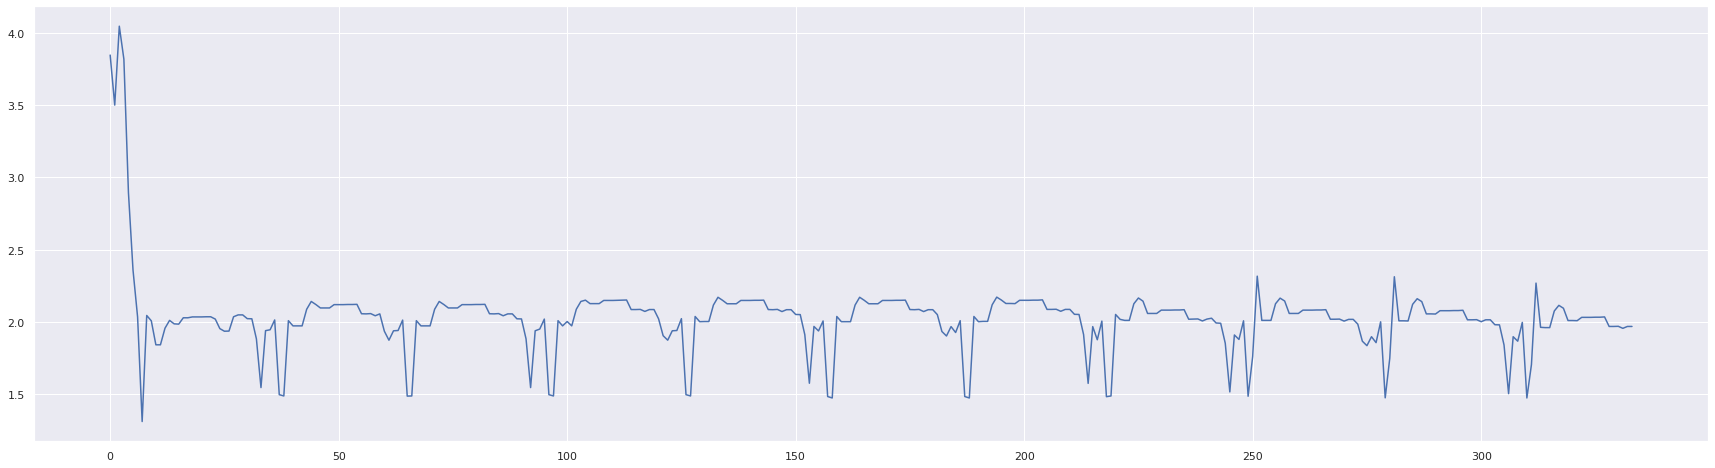

In [154]:
submit['광진구'].plot()

<AxesSubplot:>

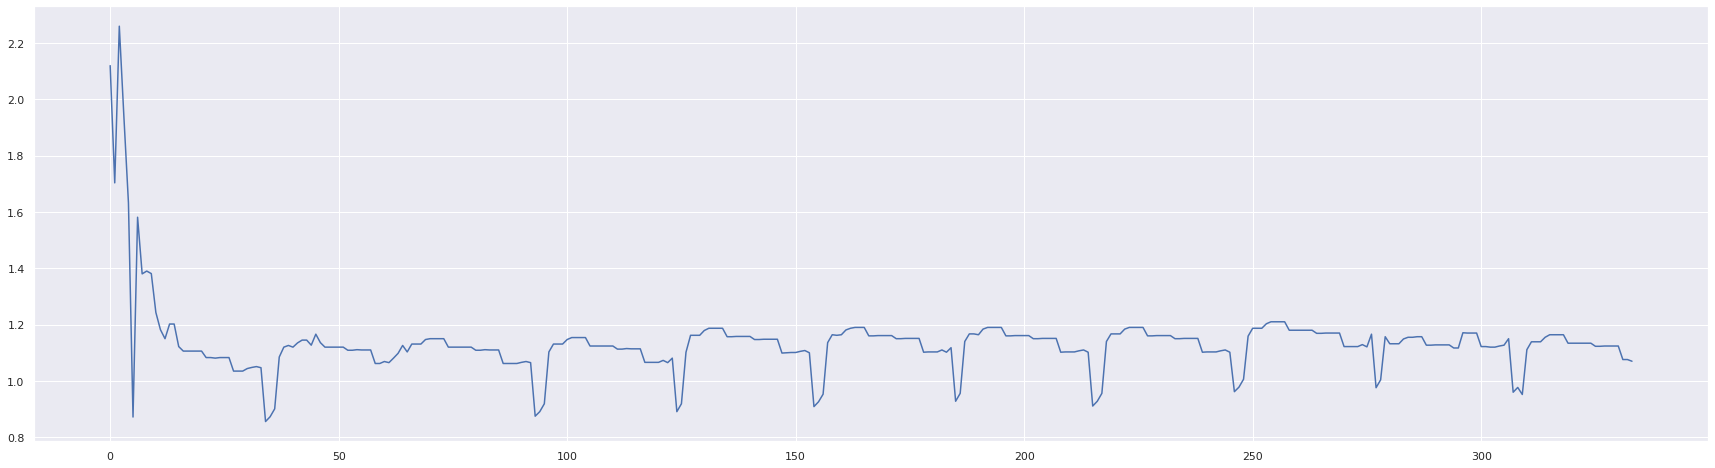

In [155]:
submit['동대문구'].plot()

<AxesSubplot:>

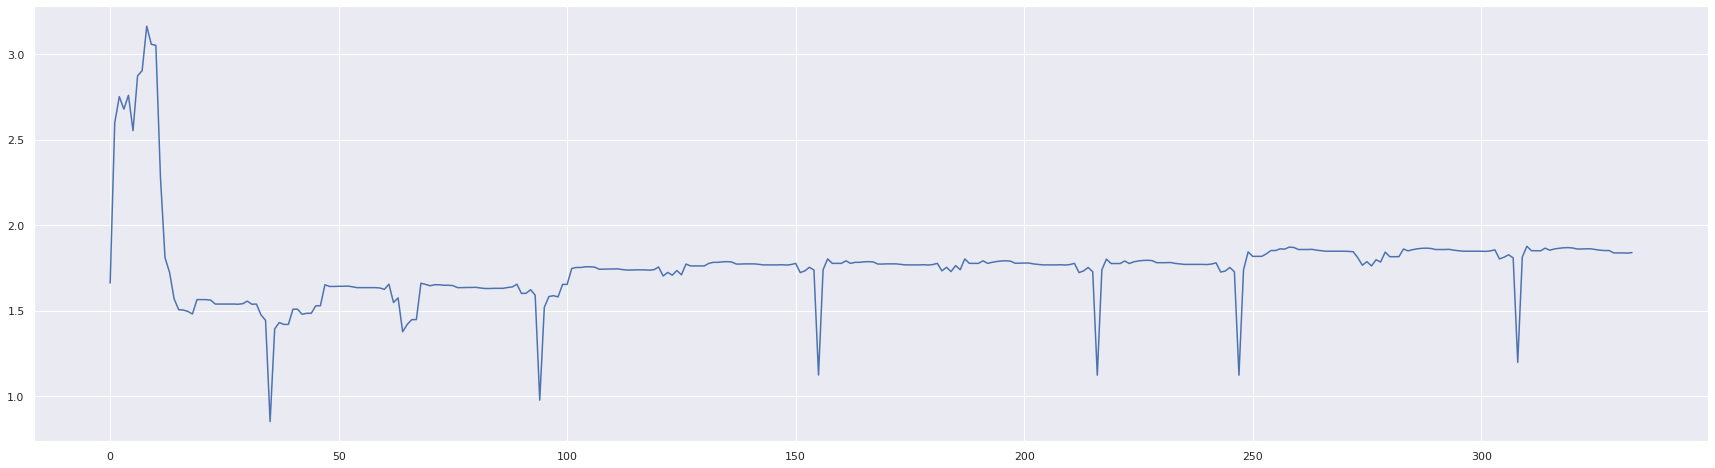

In [156]:
submit['성동구'].plot()

<AxesSubplot:>

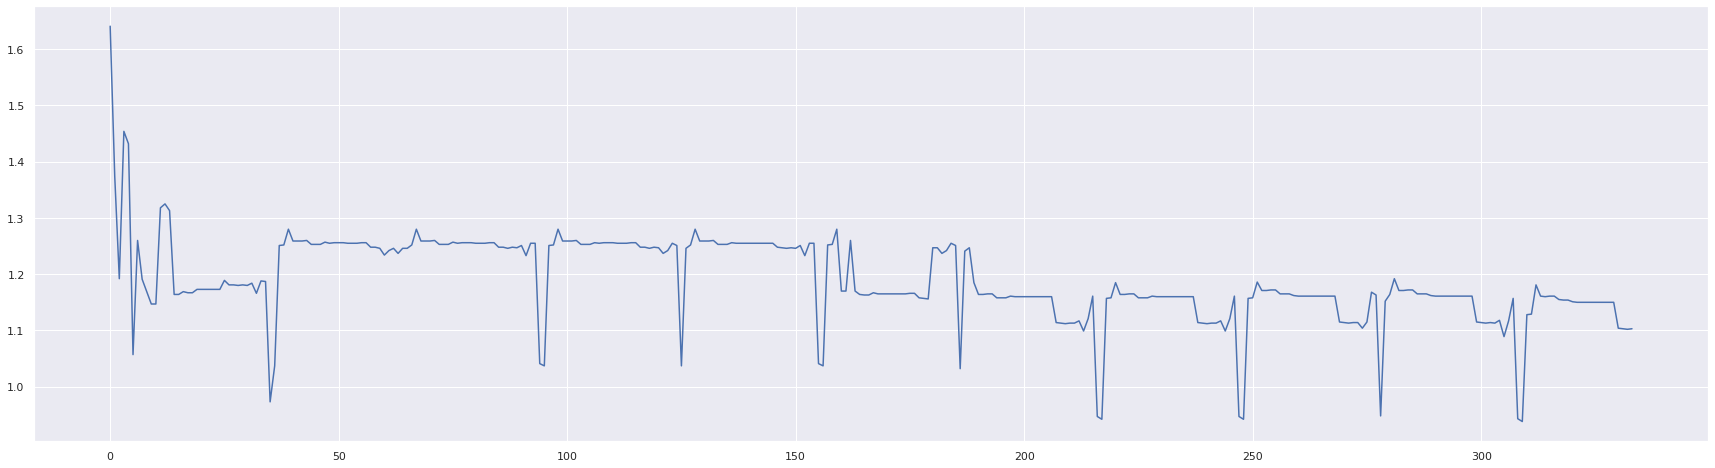

In [157]:
submit['중랑구'].plot()

In [158]:
submit.to_csv('submission/submit_1202_1.csv', index=False)